In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=a115eb93bd8b8e0b2db2862ce1b57ce0813fc982efa4aa365e4c0d1fc572d30a
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [4]:
import json
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *

spark = SparkSession.builder \
    .appName("ChampionSelection") \
    .getOrCreate()

champion_df = spark.read.csv('/content/drive/MyDrive/champtionData.csv', sep=",", inferSchema=True, header=True)
champion_lost_df = spark.read.csv('/content/drive/MyDrive/chamption_withLost_Data.csv', sep=",", inferSchema=True, header=True)
champion_lost_df = champion_lost_df.select("Lost_Champ1", "Lost_Champ2", "Lost_Champ3", "Lost_Champ4", "Lost_Champ5")
champion_df.show()
champion_lost_df.show()


+---+------------+---------------+---------------+------------------+-----------------+--------------------+----------------+-------+
|_c0|      Champ1|         Champ2|         Champ3|            Champ4|           Champ5|                Bans|Duration in Mins|Version|
+---+------------+---------------+---------------+------------------+-----------------+--------------------+----------------+-------+
|  0|  TOP,Aatrox|    JUNGLE,Zyra|   BOTTOM,Yasuo|   MIDDLE,Katarina|  UTILITY,Alistar|None, Draven, Rek...|           24.73|14.13.5|
|  1| TOP,DrMundo|  JUNGLE,Khazix|    MIDDLE,Ahri|      BOTTOM,Kaisa| UTILITY,Nautilus|Zed, Aatrox, Jinx...|           31.25|14.15.6|
|  2|   TOP,Kayle|  JUNGLE,Aurora|  MIDDLE,Viktor|     BOTTOM,Ezreal|  UTILITY,Warwick|Udyr, Smolder, Bl...|           35.12|14.15.6|
|  3|    TOP,Yone| JUNGLE,Karthus|   MIDDLE,Galio|      BOTTOM,Kaisa|     UTILITY,Lulu|Lillia, Draven, Z...|            28.7|14.15.6|
|  4|    TOP,Yone| JUNGLE,Kindred|  MIDDLE,Aurora|BOTTOM,MissF

In [5]:
def version_group(version):
    major_minor_version = '.'.join(version.split('.')[:2])
    return major_minor_version

extract_version_udf = udf(version_group, StringType())

In [6]:
champion_df = champion_df.withColumn("VersionGroup", extract_version_udf(champion_df["Version"]))
champion_df.show()

+---+------------+---------------+---------------+------------------+-----------------+--------------------+----------------+-------+------------+
|_c0|      Champ1|         Champ2|         Champ3|            Champ4|           Champ5|                Bans|Duration in Mins|Version|VersionGroup|
+---+------------+---------------+---------------+------------------+-----------------+--------------------+----------------+-------+------------+
|  0|  TOP,Aatrox|    JUNGLE,Zyra|   BOTTOM,Yasuo|   MIDDLE,Katarina|  UTILITY,Alistar|None, Draven, Rek...|           24.73|14.13.5|       14.13|
|  1| TOP,DrMundo|  JUNGLE,Khazix|    MIDDLE,Ahri|      BOTTOM,Kaisa| UTILITY,Nautilus|Zed, Aatrox, Jinx...|           31.25|14.15.6|       14.15|
|  2|   TOP,Kayle|  JUNGLE,Aurora|  MIDDLE,Viktor|     BOTTOM,Ezreal|  UTILITY,Warwick|Udyr, Smolder, Bl...|           35.12|14.15.6|       14.15|
|  3|    TOP,Yone| JUNGLE,Karthus|   MIDDLE,Galio|      BOTTOM,Kaisa|     UTILITY,Lulu|Lillia, Draven, Z...|          

In [ ]:
version_df = champion_df.groupBy("VersionGroup").agg({"*": "count"}).withColumnRenamed("count(1)", "count")
version_df.show()

+------------+-----+
|VersionGroup|count|
+------------+-----+
|        14.8|    1|
|       14.12|  125|
|       14.13|  219|
|       14.15|  322|
|       14.11|   48|
|        14.7|    3|
|       14.14|  277|
|       14.10|    5|
+------------+-----+



In [7]:
#the most winning champion at different version for different position(Top, JUG, MID, BOT, Utility)
position_df = champion_df.withColumn("Position1", split(col("Champ1"), ",")[0]) \
       .withColumn("Champion1", split(col("Champ1"), ",")[1]) \
       .withColumn("Position2", split(col("Champ2"), ",")[0]) \
       .withColumn("Champion2", split(col("Champ2"), ",")[1]) \
       .withColumn("Position3", split(col("Champ3"), ",")[0]) \
       .withColumn("Champion3", split(col("Champ3"), ",")[1]) \
       .withColumn("Position4", split(col("Champ4"), ",")[0]) \
       .withColumn("Champion4", split(col("Champ4"), ",")[1]) \
       .withColumn("Position5", split(col("Champ5"), ",")[0]) \
       .withColumn("Champion5", split(col("Champ5"), ",")[1])
position_df.show(truncate=False)

champion_lost_df = champion_lost_df.withColumn("Position1", split(col("Lost_Champ1"), ",")[0]) \
       .withColumn("Champion1", split(col("Lost_Champ1"), ",")[1]) \
       .withColumn("Position2", split(col("Lost_Champ2"), ",")[0]) \
       .withColumn("Champion2", split(col("Lost_Champ2"), ",")[1]) \
       .withColumn("Position3", split(col("Lost_Champ3"), ",")[0]) \
       .withColumn("Champion3", split(col("Lost_Champ3"), ",")[1]) \
       .withColumn("Position4", split(col("Lost_Champ4"), ",")[0]) \
       .withColumn("Champion4", split(col("Lost_Champ4"), ",")[1]) \
       .withColumn("Position5", split(col("Lost_Champ5"), ",")[0]) \
       .withColumn("Champion5", split(col("Lost_Champ5"), ",")[1])

champion_lost_df = champion_lost_df.select("Position1", "Champion1","Position2", "Champion2","Position3", "Champion3","Position4", "Champion4","Position5", "Champion5")
champion_lost_df.show(truncate=False)

+---+------------+---------------+---------------+------------------+-----------------+----------------------------------------------------+----------------+-------+------------+---------+---------+---------+---------+---------+---------+---------+-----------+---------+---------+
|_c0|Champ1      |Champ2         |Champ3         |Champ4            |Champ5           |Bans                                                |Duration in Mins|Version|VersionGroup|Position1|Champion1|Position2|Champion2|Position3|Champion3|Position4|Champion4  |Position5|Champion5|
+---+------------+---------------+---------------+------------------+-----------------+----------------------------------------------------+----------------+-------+------------+---------+---------+---------+---------+---------+---------+---------+-----------+---------+---------+
|0  |TOP,Aatrox  |JUNGLE,Zyra    |BOTTOM,Yasuo   |MIDDLE,Katarina   |UTILITY,Alistar  |None, Draven, Rek'Sai, Jinx, Akali                  |24.73           |

In [ ]:
from pyspark.sql.functions import expr, col, when

def winrate_all_positions(df, position_columns, champion_columns):
    position_results = {}

    for position in ["TOP", "JUNGLE", "MIDDLE", "BOTTOM", "UTILITY"]:
        count_exprs = []
        for pos_col, champ_col in zip(position_columns, champion_columns):
            count_exprs.append(when(col(pos_col) == position, col(champ_col)).alias(champ_col + f"_{position.lower()}"))

        df_with_position = df.select("*", *count_exprs)

        position_count_df = df_with_position.selectExpr(
            "stack({}, {}) as Champion".format(
                len(count_exprs),
                ", ".join([f"{col_name}_{position.lower()}" for col_name in champion_columns])
            )
        ).where(col("Champion").isNotNull()) \
          .groupBy("Champion") \
          .count() \
          .withColumnRenamed("count", f"{position}_count") \
          .orderBy(col(f"{position}_count").desc())
        position_results[position] = position_count_df

    return position_results

position_columns = ["Position1", "Position2", "Position3", "Position4", "Position5"]
champion_columns = ["Champion1", "Champion2", "Champion3", "Champion4", "Champion5"]

win_position_counts = winrate_all_positions(position_df, position_columns, champion_columns)
lost_position_counts = winrate_all_positions(champion_lost_df, position_columns, champion_columns)

for position, df_result in win_position_counts.items():
    df_result.show()
for position, df_result in lost_position_counts.items():
    df_result.show()

+-----------+---------+
|   Champion|TOP_count|
+-----------+---------+
|     Aatrox|       61|
|      Garen|       43|
|    Camille|       40|
|   Renekton|       32|
|     Darius|       30|
|  TahmKench|       27|
|        Jax|       27|
|       Sett|       26|
|   Malphite|       25|
|   Volibear|       25|
|      Nasus|       24|
|       Ornn|       24|
|      Riven|       24|
|     KSante|       20|
|    DrMundo|       20|
|       Yone|       19|
|Mordekaiser|       19|
|   Pantheon|       18|
|     Kennen|       18|
|TwistedFate|       17|
+-----------+---------+
only showing top 20 rows

+--------+------------+
|Champion|JUNGLE_count|
+--------+------------+
| Hecarim|          56|
|   Viego|          46|
|  Khazix|          45|
|    Udyr|          42|
| Nidalee|          39|
|  Lillia|          34|
|  Graves|          34|
|  LeeSin|          32|
|    Kayn|          31|
| Belveth|          31|
| Kindred|          30|
| Shyvana|          30|
|     Zac|          29|
| Karthus|    

In [ ]:
def calculate_win_rate(win_counts, lost_counts):
  win_rate = {}
  for position in ["TOP", "JUNGLE", "MIDDLE", "BOTTOM", "UTILITY"]:
    win_df = win_position_counts[position]
    lost_df = lost_position_counts[position]

    total_df = win_df.join(lost_df.withColumnRenamed(f"{position}_count", f"{position}_loss_count"), on = "Champion", how="left").fillna(0)
    total_df = total_df.withColumn(f"{position}_total_games", col(f"{position}_count") + col(f"{position}_loss_count"))
    total_df = total_df.filter((col(f"{position}_count") > 5) & (col(f"{position}_loss_count") > 5)).withColumn(f"{position}_winrate", (round((col(f"{position}_count") / col(f"{position}_total_games")) * 100)))
    win_rate[position] = total_df.select("Champion", f"{position}_count", f"{position}_loss_count", f"{position}_total_games",f"{position}_winrate").orderBy(col(f"{position}_winrate").desc())

  return win_rate

all_position_counts = calculate_win_rate(win_position_counts, lost_position_counts)
for position, df_result in all_position_counts.items():
    df_result.show()


+-----------+---------+--------------+---------------+-----------+
|   Champion|TOP_count|TOP_loss_count|TOP_total_games|TOP_winrate|
+-----------+---------+--------------+---------------+-----------+
|    Smolder|       15|             7|             22|       68.0|
|  Gangplank|       12|             7|             19|       63.0|
|     Rumble|       12|             7|             19|       63.0|
|    Chogath|       15|             9|             24|       63.0|
|   Pantheon|       18|            11|             29|       62.0|
| MonkeyKing|       15|            10|             25|       60.0|
|TwistedFate|       17|            12|             29|       59.0|
|      Riven|       24|            17|             41|       59.0|
|   Renekton|       32|            23|             55|       58.0|
|   Malphite|       25|            19|             44|       57.0|
|      Jayce|       16|            12|             28|       57.0|
|     Gragas|       17|            13|             30|       5

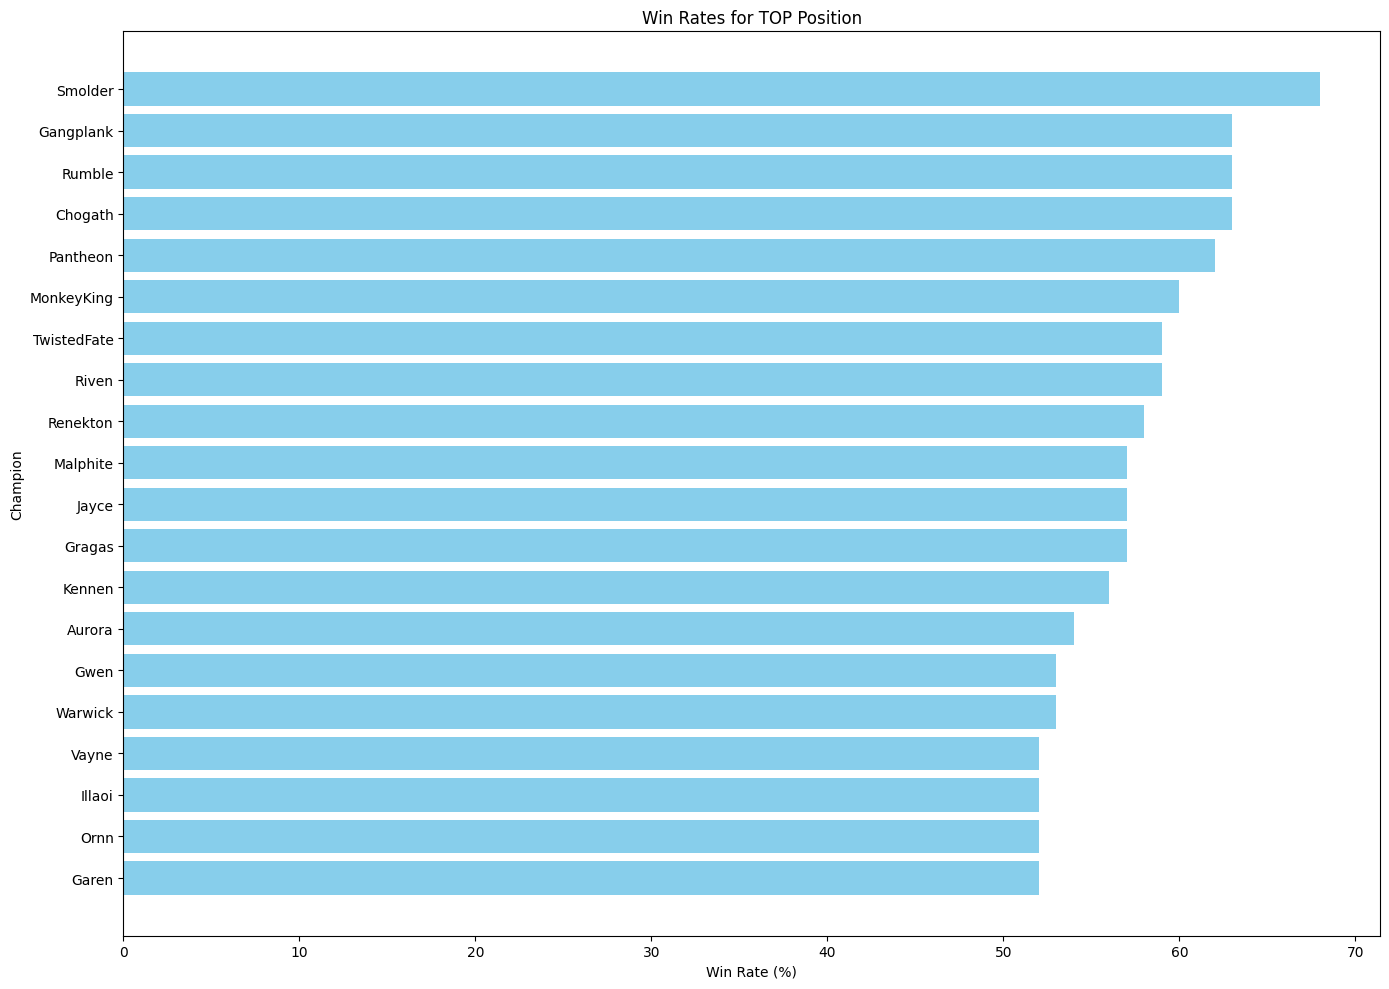

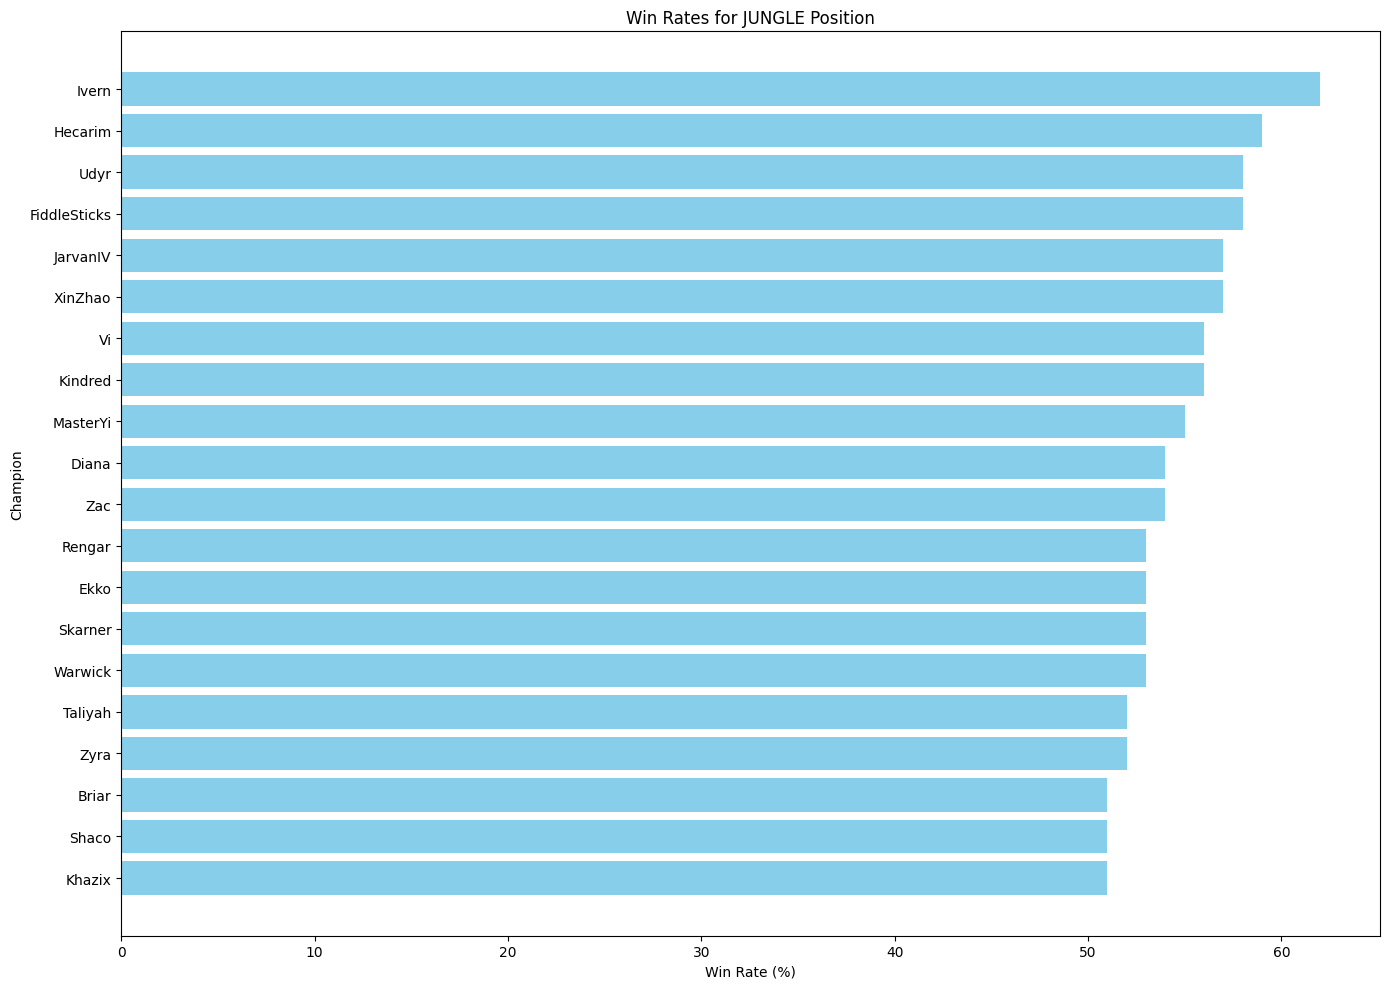

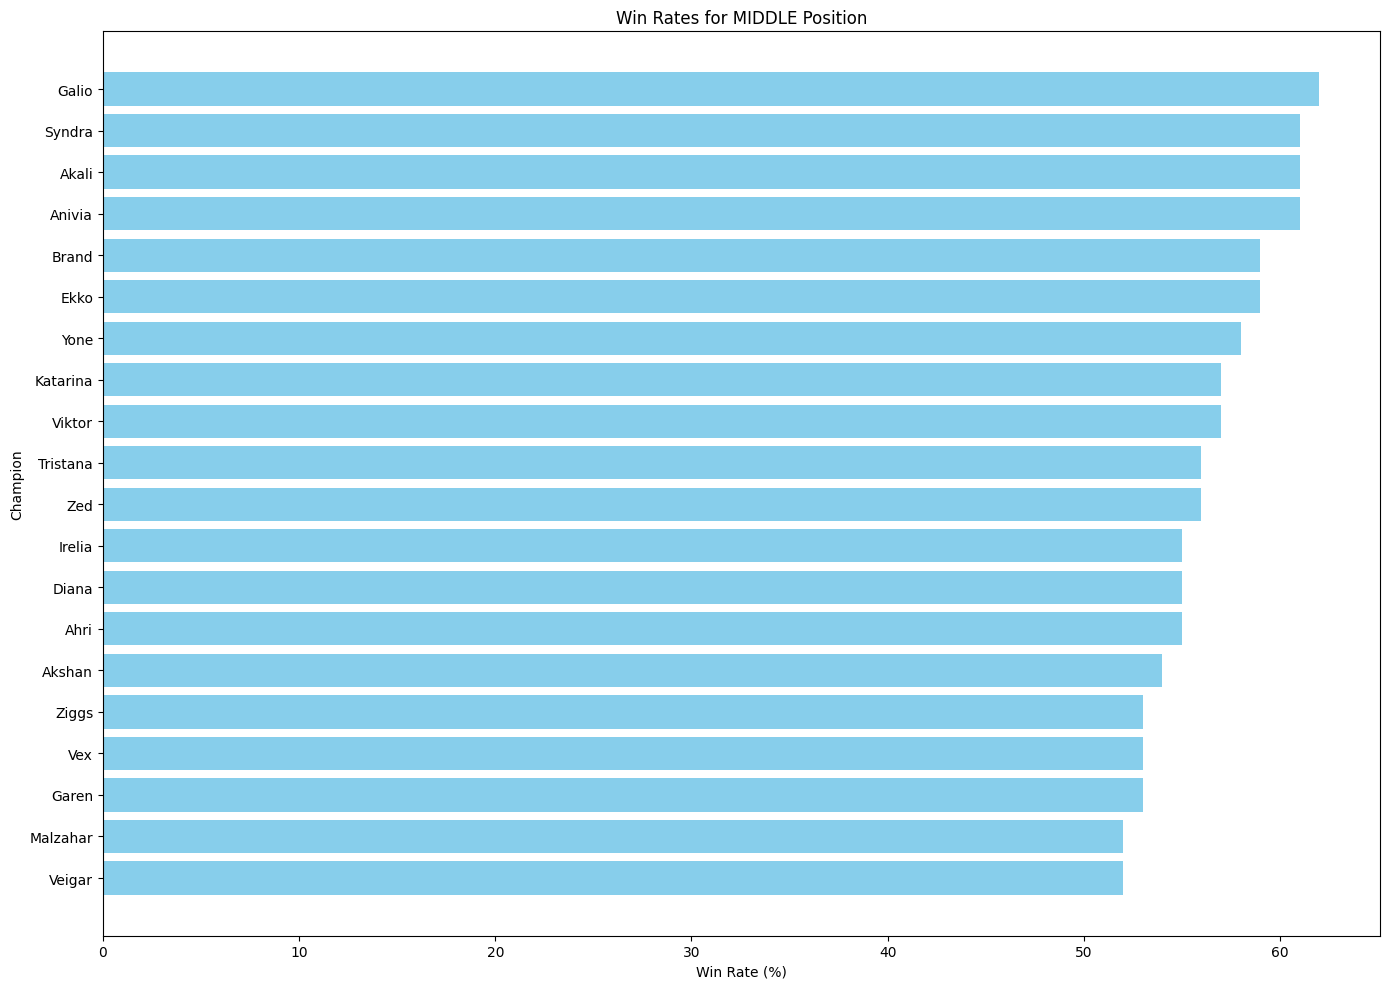

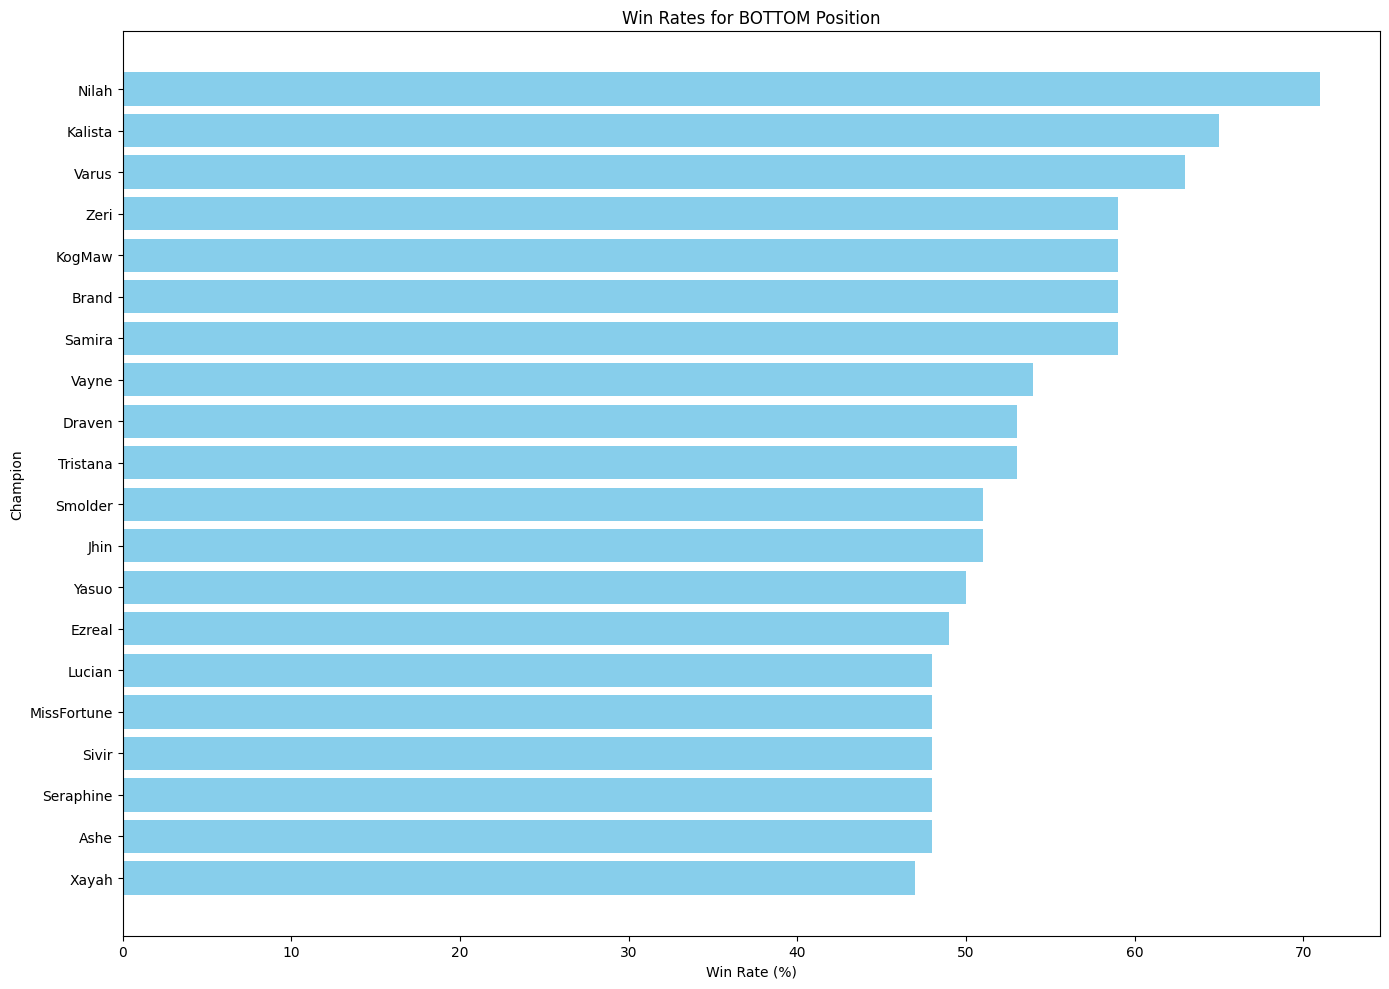

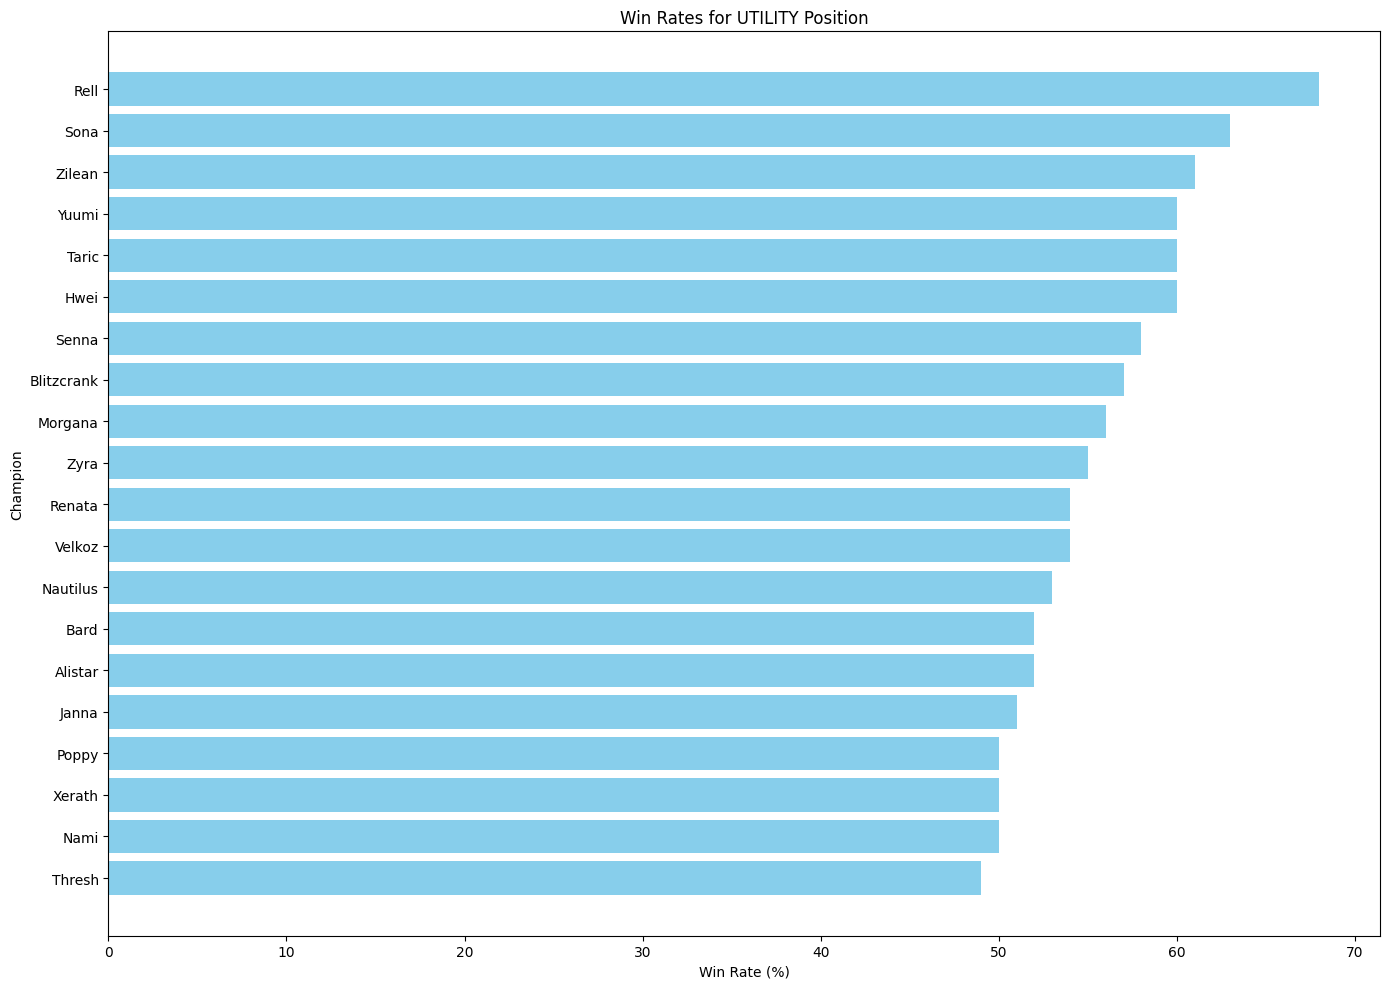

In [ ]:
import matplotlib.pyplot as plt

def plot_win_counts(win_counts):
    for position, df in win_counts.items():
        pandas_df = df.limit(20).toPandas()

        plt.figure(figsize=(14, 10))
        plt.barh(pandas_df['Champion'], pandas_df[f'{position}_winrate'], color='skyblue')
        plt.xlabel('Win Rate (%)')
        plt.ylabel('Champion')
        plt.title(f'Win Rates for {position} Position')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

plot_win_counts(all_position_counts)


In [ ]:
def find_most_banned_for_champion(df, champion):

  df_filtered = df.filter(
        (col("Champion1") == champion) |
        (col("Champion2") == champion) |
        (col("Champion3") == champion) |
        (col("Champion4") == champion) |
        (col("Champion5") == champion)
    )
  bans_df = df_filtered.withColumn("BannedChampion", explode(split(col("Bans"), ", ")))

  ban_counts = bans_df.groupBy("BannedChampion").count().orderBy(col("count").desc())

  ban_counts = ban_counts.withColumn("SelectedChampion", lit(champion))

  return ban_counts.limit(3)

bans_for_champion_df = None

for position, result in all_position_counts.items():
  #count = 0
  for row in result.collect():
    champion = row["Champion"]
    ban_counts = find_most_banned_for_champion(position_df, champion)

    #count += 1
    #if count == 5:
      #break



    if bans_for_champion_df is None:
      bans_for_champion_df = ban_counts
    else:
      bans_for_champion_df = bans_for_champion_df.unionByName(ban_counts)



bans_for_champion_df.limit(10).show()


+--------------+-----+----------------+
|BannedChampion|count|SelectedChampion|
+--------------+-----+----------------+
|        Aurora|   20|         Smolder|
|        Draven|   17|         Smolder|
|          None|   13|         Smolder|
|        Aurora|    5|       Gangplank|
|           Zed|    3|       Gangplank|
+--------------+-----+----------------+



In [9]:
intervals = [(15, 30), (30, 45), (45, 60)]
top_time_df = None
for start, end in intervals:

    df_filtered = champion_df.filter((col("Duration in Mins") >= start) & (col("Duration in Mins") < end))


    df_grouped = df_filtered.groupBy("Champ1", "Champ2", "Champ3", "Champ4", "Champ5").agg(avg("Duration in Mins").alias("Avg Duration"))


    df_top_5 = df_grouped.orderBy(rand()).limit(10)


    df_top_5 = df_top_5.withColumn("Interval", lit(f"{start}-{end} mins"))

    if top_time_df is None:
          top_time_df = df_top_5
    else:
          top_time_df = top_time_df.union(df_top_5)


top_time_df.show(truncate=False)

+------------------+-------------------+---------------+--------------+------------------+------------+----------+
|Champ1            |Champ2             |Champ3         |Champ4        |Champ5            |Avg Duration|Interval  |
+------------------+-------------------+---------------+--------------+------------------+------------+----------+
|MIDDLE,Nasus      |JUNGLE,Ekko        |TOP,Neeko      |BOTTOM,KogMaw |UTILITY,Lulu      |17.7        |15-30 mins|
|TOP,Tryndamere    |JUNGLE,Gragas      |MIDDLE,Yasuo   |BOTTOM,Zeri   |UTILITY,Rakan     |22.7        |15-30 mins|
|TOP,TahmKench     |JUNGLE,FiddleSticks|MIDDLE,Talon   |BOTTOM,Ezreal |UTILITY,Bard      |26.37       |15-30 mins|
|TOP,Sett          |JUNGLE,Khazix      |MIDDLE,Yasuo   |BOTTOM,Brand  |UTILITY,Sona      |27.5        |15-30 mins|
|TOP,Tryndamere    |JUNGLE,Udyr        |MIDDLE,Akshan  |BOTTOM,Kalista|UTILITY,TahmKench |23.75       |15-30 mins|
|TOP,Shen          |JUNGLE,XinZhao     |MIDDLE,Azir    |BOTTOM,Zeri   |UTILITY,R

<ipython-input-11-9d88f92e2a62>:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


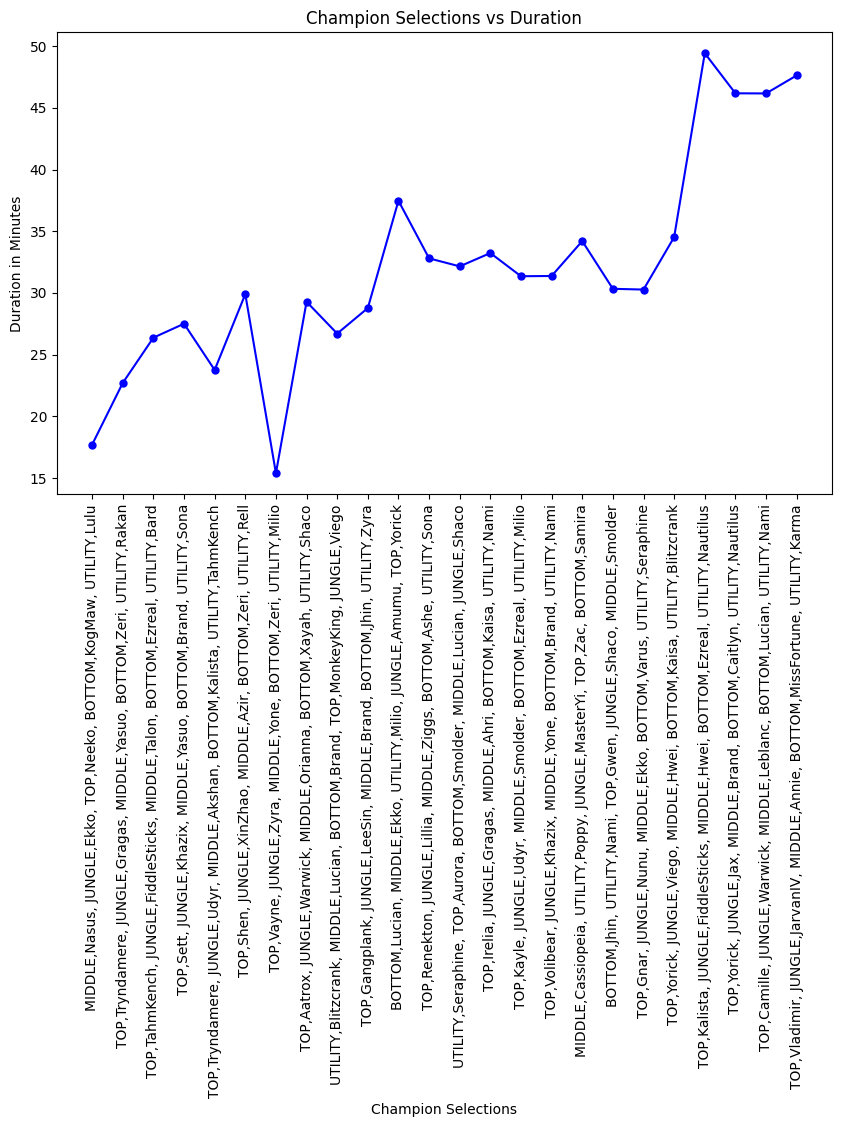

In [11]:
import pandas as pd
import matplotlib.pyplot as plt


pd_time = top_time_df.toPandas()
plt.figure(figsize=(10, 6))
pd_time['Champion_Selection'] = pd_time['Champ1'] + ", " + pd_time['Champ2'] + ", " + pd_time['Champ3'] + ", " + pd_time['Champ4'] + ", " + pd_time['Champ5']
plt.plot(pd_time['Champion_Selection'], pd_time['Avg Duration'], 'bo-', markersize=5)
plt.xticks(rotation=90)
plt.xlabel('Champion Selections')
plt.ylabel('Duration in Minutes')
plt.title('Champion Selections vs Duration')
plt.tight_layout()
plt.show()


In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor

team_champion = top_time_df
team_champion = team_champion.dropna()
team_champion = team_champion.withColumn("Champion_Selection", concat_ws(", ", "Champ1", "Champ2", "Champ3", "Champ4", "Champ5"))

indexers_team = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid='keep') for col in ["Champ1", "Champ2", "Champ3", "Champ4", "Champ5"]]
assembler_team = VectorAssembler(inputCols=[col+"_index" for col in ["Champ1", "Champ2", "Champ3", "Champ4", "Champ5"]], outputCol="features")

train_team, test_team = team_champion.randomSplit([0.8, 0.2])

rf_team = RandomForestRegressor(labelCol="Avg Duration", featuresCol="features", numTrees=100)
pipeline_team = Pipeline(stages=indexers_team + [assembler_team, rf_team])
model_team = pipeline_team.fit(train_team)

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

predictions_team = model_team.transform(test_team)
evaluator_team = RegressionEvaluator(labelCol="Avg Duration", predictionCol="prediction", metricName="rmse")
rmse_team = evaluator_team.evaluate(predictions_team)
print(f"Team Composition Model RMSE: {rmse_team}")

Team Composition Model RMSE: 14.739070807126883


In [ ]:
top_win_rate = all_position_counts['TOP']

assembler = VectorAssembler(inputCols=["TOP_count", "TOP_total_games"], outputCol="features")
assembled_df = assembler.transform(top_win_rate)

rf = RandomForestRegressor(labelCol="TOP_winrate", featuresCol="features", numTrees=100)
train_df, test_df = assembled_df.randomSplit([0.8, 0.2], seed=1234)
model = rf.fit(train_df)

In [ ]:
predictions = model.transform(test_df)
evaluator = RegressionEvaluator(labelCol="TOP_winrate", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 7.765282329795493
